In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# GPU 사용 가능 여부 확인 -> GPU or CPU 선택

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [3]:
# 데이터 준비 1.
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# 데이터 준비 2.
train_dataset = datasets.CIFAR10(root="data-files",
                               train=True,
                               download=True,
                               # transform=transforms.ToTensor(),
                               transform=transform)

test_dataset = datasets.CIFAR10(root="data-files",
                              train=False,
                              download=True,
                              # transform=transforms.ToTensor(),
                              transform=transform)

100%|██████████| 170M/170M [00:50<00:00, 3.37MB/s] 


Extracting data-files\cifar-10-python.tar.gz to data-files
Files already downloaded and verified


In [5]:
# 데이터 준비 3.

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)

In [6]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])


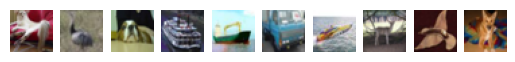

tensor([3, 2, 5, 8, 8, 9, 8, 4, 2, 5])

In [14]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].permute(1, 2, 0), cmap="gray_r")
plt.show()
y[:10]

In [27]:
# 모델 구조 설계

class Cifar10Cnn(nn.Module):
    def __init__(self):
        super(Cifar10Cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)        

        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [28]:
# 학습 도구 구성
model = Cifar10Cnn().to(device)
# loss = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)

Cifar10Cnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [29]:
# 훈련 함수 정의 (학습 설계)
def train(model, train_loader, optimizer):
    model.train() # train mode로 설정
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 300 == 0:
            print(f"Batch : {idx}, Loss : {loss.item()}")

In [30]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # evaluation mode로 설정 -> batch-normalization, drop-out 수행 중지
    with torch.no_grad(): # 가중치 업데이트 수행 중지
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total /= ( len(test_dataset) / 32 )
    accuracy = correct_total / len(test_dataset)

    return loss_total, accuracy



In [31]:
# 학습 실행

for epoch in range(10):    
    train(model, train_loader, optimizer)
    loss, accuracy = evaluate(model, test_loader)
    print(f"Epoch : {epoch + 1}, Loss: {loss}, Accuracy : {accuracy}")

    

Batch : 0, Loss : 2.3032639026641846
Batch : 300, Loss : 2.159883737564087
Batch : 600, Loss : 2.2483034133911133
Batch : 900, Loss : 2.1249775886535645
Batch : 1200, Loss : 2.072183609008789
Batch : 1500, Loss : 2.2537758350372314
Epoch : 1, Loss: 2.0614164669036867, Accuracy : 0.3974
Batch : 0, Loss : 1.997743844985962
Batch : 300, Loss : 1.9708030223846436
Batch : 600, Loss : 2.0580039024353027
Batch : 900, Loss : 2.021127223968506
Batch : 1200, Loss : 2.062729597091675
Batch : 1500, Loss : 2.046203851699829
Epoch : 2, Loss: 2.032047647857666, Accuracy : 0.4258
Batch : 0, Loss : 2.01536226272583
Batch : 300, Loss : 1.9907970428466797
Batch : 600, Loss : 1.9645359516143799
Batch : 900, Loss : 2.0654923915863037
Batch : 1200, Loss : 2.097151756286621
Batch : 1500, Loss : 1.9013785123825073
Epoch : 3, Loss: 1.9995422748565674, Accuracy : 0.4624
Batch : 0, Loss : 2.0294549465179443
Batch : 300, Loss : 1.9010692834854126
Batch : 600, Loss : 2.0208022594451904
Batch : 900, Loss : 2.012995

In [32]:
evaluate(model, test_loader)

(1.9093283863067627, 0.553)